# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
1. Изучить данные. Заполнить пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
2. Подготовить выборки для обучения моделей.
3. Обучить разные модели.
4. Проанализировать время обучения, время предсказания и качество моделей.
5. Опираясь на критерии заказчика, выбрать лучшую модель.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from catboost import CatBoostRegressor
import time

In [2]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Приведём столбцы с датой к формату datetime64
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


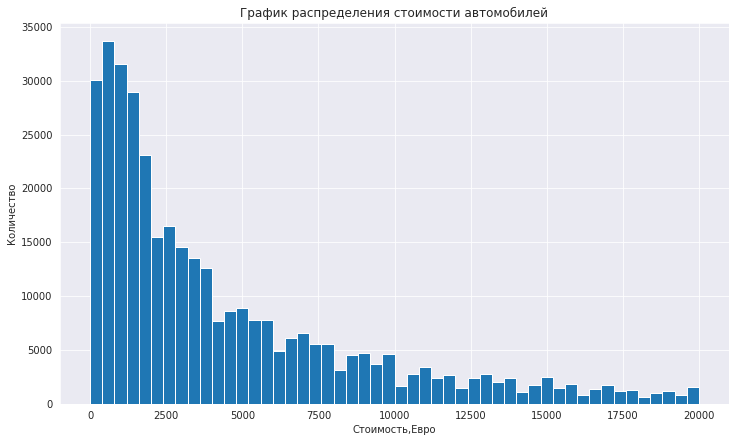

In [6]:
# Посмотрим на целевой столбец Price с ценой автомобилей
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [7]:
data.loc[data['Price'] < 10]['Price'].count()

12028

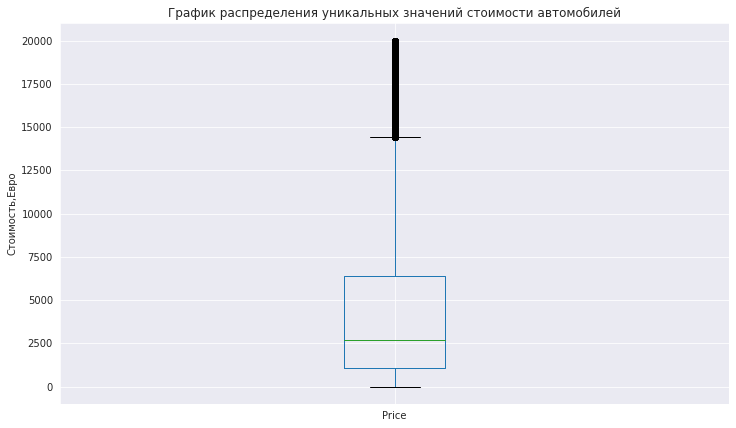

In [8]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')
plt.ylabel('Стоимость,Евро')
plt.show()

Удалим данные стоимости автомобилей ниже 10€, т.к. такие значения нам не интересны. Владельцы авто могут указывать такую цену только за разбитую машину под восставновление, либо с расчётом на равноценный обмен.

In [9]:
data = data.query('Price> 10')

In [10]:
data.loc[data['Price'] < 10]['Price'].count()

0

Посмотрим на отсутствующие значения колонки "VehicleType" и заполним их значением N/A

In [11]:
data['VehicleType']=data['VehicleType'].fillna('N/A')
data.VehicleType.isna().sum()

0

Проверим столбец "RegistrationYear" на уникальные значения

In [12]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

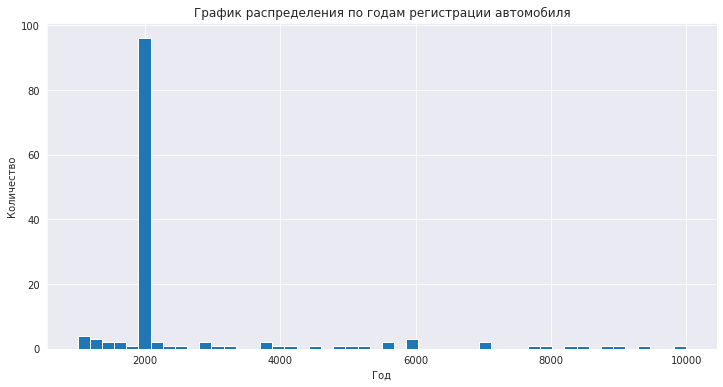

In [13]:
pd.Series(list(data.RegistrationYear.unique())).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения по годам регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

Вычислим дату формирования списков авто и отсортируем данные о регистрации по этой дате, а так же удалим совсем старые, которым более 67 лет.

In [14]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [15]:
data=data.query('RegistrationYear >= 1950 & RegistrationYear < 2016')

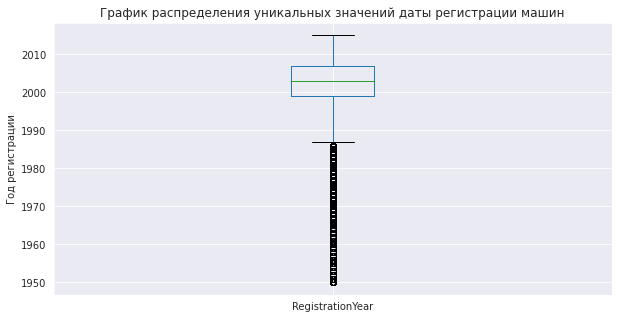

In [16]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации машин')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

Посмотрим на отсутствующие данные по столбцу "Gearbox"

In [17]:
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,N/A,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
94,2016-03-28 16:37:43,8390,N/A,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28,0,29221,2016-03-30 07:44:59
110,2016-04-03 03:57:26,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,2016-04-03,0,82110,2016-04-03 08:53:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,N/A,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,N/A,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


Информация о коробкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении. В связи с этим лучше избавиться от этих данных во избежании лишнего "шума", чем заполнить пропуски каким-то значением. К тому же по данным строкам есть множество ошибочных значений и пропусков в других столбцах.

In [18]:
data.dropna(subset=['Gearbox'], inplace=True)

In [19]:
data.Gearbox.unique()

array(['manual', 'auto'], dtype=object)

Посмотрим на значения в столбце "Power"

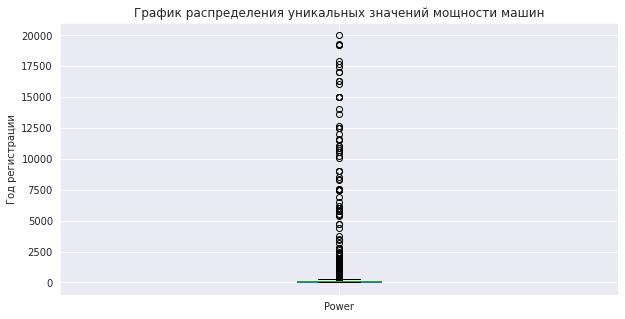

In [20]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности машин')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

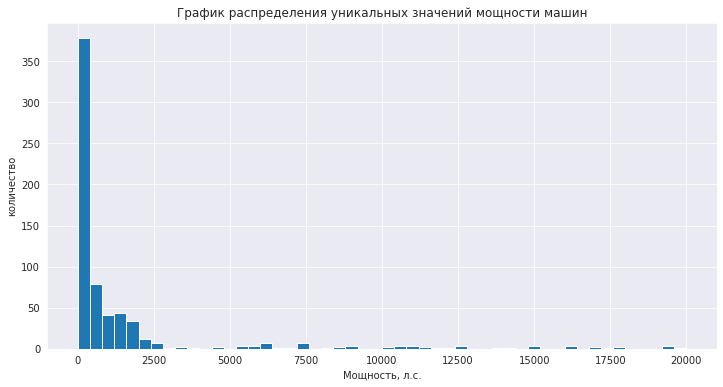

In [21]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности машин')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

Очевидно, что таких мощностей не бывает и такие данные так же требуется удалить из нашей базы данных.

In [22]:
data.Power.describe()

count    305583.000000
mean        116.444030
std         183.704529
min           0.000000
25%          75.000000
50%         109.000000
75%         145.000000
max       20000.000000
Name: Power, dtype: float64

Удалим данные о мощности дигателя свыше 2500 л.с. и менее 15 л.с.

In [23]:
data=data.query('Power > 15 & Power < 2500')

Просмотрим пропущенные значения по столбцу "Model"

In [24]:
data.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25


Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из данных.

In [25]:
data.dropna(subset=['Model'], inplace=True)

Посмотрим на данные о пробеге авто в столбце "Kilometer"

In [26]:
data.Kilometer.describe()

count    275019.000000
mean     128224.722656
std       36540.539811
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Данный столбец не требует изменений.

Посмотрим на значения в столбце "RegistrationMonth"

In [27]:
data.RegistrationMonth.describe()

count    275019.000000
mean          6.070930
std           3.545621
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [28]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9])

In [29]:
data.RegistrationMonth.value_counts()

3     28779
6     25773
4     24158
5     24009
7     22317
10    21615
12    19984
11    19894
9     19821
1     18997
8     18508
2     17754
0     13410
Name: RegistrationMonth, dtype: int64

Т.к. этот параметр не имеет особого значения на ценообразование, а терять данные нам не хочется, заменим нулевые значения на среднее значение

In [30]:
data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] =6

In [31]:
data.loc[data['RegistrationMonth'] == 6].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
18,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,6,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
44,2016-03-17 12:44:43,3900,small,2008,auto,61,fortwo,80000,6,petrol,smart,NaN,2016-03-17,0,21073,2016-03-19 11:46:17


In [32]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9])

Посмотроим на значения в столбце "FuelType"

In [33]:
data.FuelType.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [34]:
data.FuelType.value_counts()

petrol      175847
gasoline     84240
lpg           4315
cng            455
hybrid         174
other           70
electric        36
Name: FuelType, dtype: int64

In [35]:
data.FuelType.isna().sum()

9882

Заполним отсутствующие значения как "other"

In [36]:
data['FuelType']=data['FuelType'].fillna('other')

In [37]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'mitsubishi', 'kia', 'hyundai', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Здесь ничего дополнять или удалять не требуется

Посмотрим на значения в столбце "Repaired"

In [38]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [39]:
data.Repaired.isna().sum()

35042

Очевидно, что эти данные лучше заполнить N/A, чем потерять 39000 строк остального массива данных

In [40]:
data['Repaired']=data['Repaired'].fillna('N/A')

Посмотрим на значения в столбце "DateCreated"

In [41]:
data.DateCreated.describe()

count                  275019
unique                    105
top       2016-04-03 00:00:00
freq                    10846
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

Посмотрим на значения в столбце "NumberOfPictures"

In [42]:
data.NumberOfPictures.describe()

count    275019.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

В данном столбце нет никакой пользы для обучения модели, т.к. кроме нулей здесь значений нет. Такой столбец лучше так же исключить из списка

In [43]:
data=data.drop(['NumberOfPictures'], axis=1)

Посмотрим на значения в столбце "PostalCode"

In [44]:
data.PostalCode.describe()

count    275019.000000
mean      51397.739011
std       25779.781209
min        1067.000000
25%       31020.000000
50%       50676.000000
75%       72213.000000
max       99998.000000
Name: PostalCode, dtype: float64

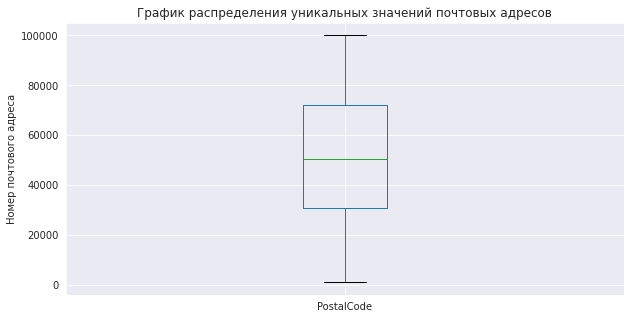

In [45]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

Распределение почтовых номеров говорит нам о том, что здесь нет необходимости что-либо корректировать, а сохранять такие данные следует только с целью вычисления географической принадлежности машин. В нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру

In [46]:
data["PostalCode"]=data["PostalCode"].astype('str')

In [47]:
first_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_index.append(case_word)
data["GeogrphyIndex"]=first_index
data["GeogrphyIndex"]=data["GeogrphyIndex"].astype('int')

In [48]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,6
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07,3
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39,6


Посмотрим на значения в столбце "LastSeen"

In [49]:
data.LastSeen.describe()

count                  275019
unique                 145033
top       2016-04-06 12:44:51
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

In [50]:
# Посмотрим коррелирущие значения после предобработки данных
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,GeogrphyIndex
Price,1.000000,0.564215,0.424934,-0.395127,0.015278,0.057080
RegistrationYear,0.564215,1.000000,0.135646,-0.349118,0.003597,0.029250
Power,0.424934,0.135646,1.000000,0.089479,0.018520,0.038337
Kilometer,-0.395127,-0.349118,0.089479,1.000000,0.002328,-0.016498
RegistrationMonth,0.015278,0.003597,0.018520,0.002328,1.000000,-0.007346
GeogrphyIndex,0.057080,0.029250,0.038337,-0.016498,-0.007346,1.000000


Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации а/м, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля

Просмотим зависимотсть целевого значения от других признаков в наших данных на графике

In [51]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeogrphyIndex'],
      dtype='object')

In [52]:
column=['Price', 'RegistrationYear',
       'Power', 'Kilometer','FuelType']

In [53]:
data_graph=data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
2,9800,2004,163,125000,gasoline
3,1500,2001,75,150000,petrol
4,3600,2008,69,90000,gasoline
5,650,1995,102,150000,petrol
6,2200,2004,109,150000,petrol


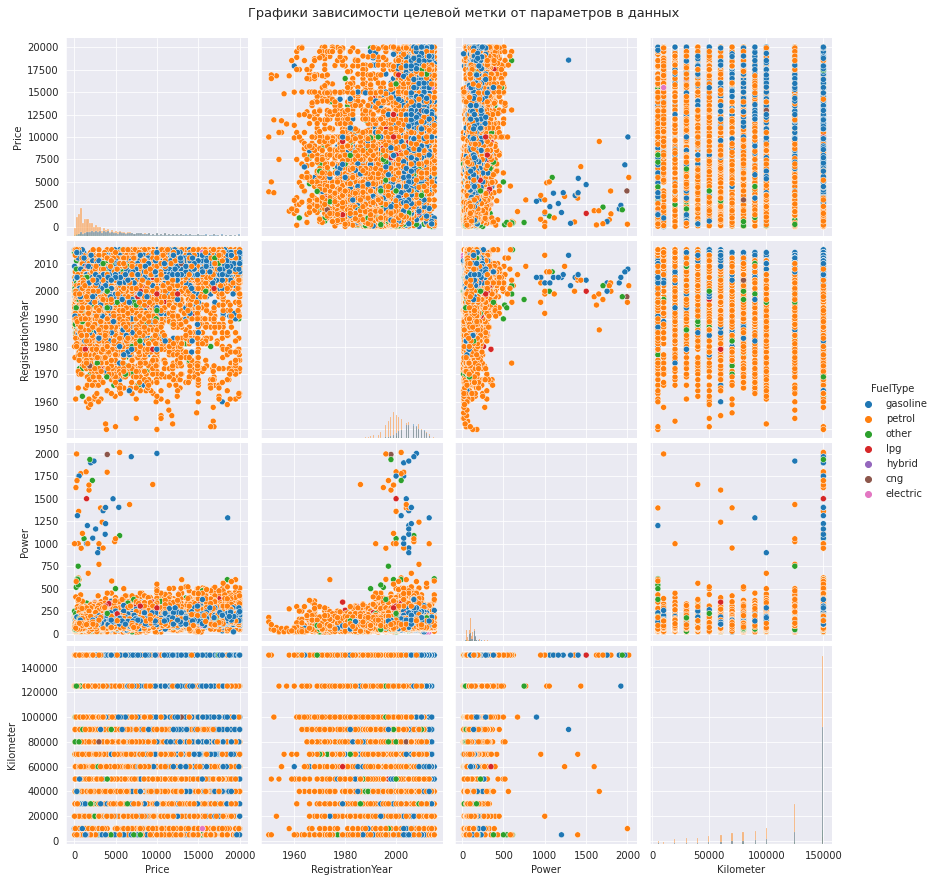

In [54]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=3, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=13)
plt.show()

Судя по графику можно сказать, что начиная с 1980 года стоимосоть а/м увеличивается с каждым годом и имеет линейную зависимость, при этом не важен тип используемого топлива. Так же из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план

Применим кодирование текстовых данных в категориальные цифровые значения методом OrdinalEncoder. Для начала выберем действительно значимые столбцы, которые могут иметьзначения в ценообразовании стоимости подержанных автомоблилей, а лишние значения мы опустим, чтобы не "зашумлять" вычисления моделей

In [55]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,6
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07,3
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39,6


In [56]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeogrphyIndex'],
      dtype='object')

In [57]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired','GeogrphyIndex']

In [58]:
# Запишем данные с интересующими нас столбцами в новый Data Frame
data_for_model = data[columns].copy()
data_for_model.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,6


In [59]:
# Сбросим индексы, после удаления лишних значений
data_for_model=data_for_model.reset_index(drop=True)

In [60]:
print('Количество явных дубликатов -', data.duplicated().sum())

Количество явных дубликатов - 4


In [61]:
data = data.drop_duplicates()
print('Количество явных дубликатов -', data.duplicated().sum())

Количество явных дубликатов - 0


In [62]:
data_for_model

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,6
...,...,...,...,...,...,...,...,...,...,...,...,...
275014,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,7
275015,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,9
275016,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2
275017,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,8


In [63]:
# Разделим данные на основную выборку и целевые признаки
features=data_for_model.drop(['Price'],axis=1)
target=data_for_model['Price']

In [64]:
# Выберем только категориальные признаки
category_features = ['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired', 'GeogrphyIndex']

In [65]:
# Также определим числовые признаки
number_features = ['RegistrationYear', 'Power', 'Kilometer']

In [67]:
#разделяю на выборки:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [68]:
#кодирую признаки через OHE:
features_ohe = pd.get_dummies(features, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.25,
                                                                                            random_state=12345)

In [70]:
scaler = StandardScaler()

scaler.fit(features_train_ohe[number_features])
features_train_ohe[number_features] = scaler.transform(features_train_ohe[number_features])
features_test_ohe[number_features] = scaler.transform(features_test_ohe[number_features])

In [71]:
# Поделим нашу выборку в пропорции 75-25, т.к. параметры мы будем искать с помощью кросс-валидации через GridSearchCV

def create_train_valid_and_test_set(features, target):
    features_train, df_valid_ant_test_features, target_train, df_valid_ant_test_target = train_test_split(
        features, target, test_size=0.4, random_state=12345)

    # теперь разделим тестовую выборку от валидационной
    features_valid, features_test, target_valid, target_test = train_test_split(
        df_valid_ant_test_features, df_valid_ant_test_target, test_size=0.5, random_state=RANDOM_STATE)

    del df_valid_ant_test_features, df_valid_ant_test_target
    
    # Проверим, что получилось
    print('Target test count = {}, Valid count = {}, Train test count = {}'.format(target_test.count(), target_valid.count(), target_train.count()))
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

def create_train_and_test_set(features, target):
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    # Проверим, что получилось
    print('Target test count = {}, Train test count = {}'.format(target_test.count(), target_train.count()))
    
    return features_train, target_train, features_test, target_test

features_train, target_train, features_test, target_test = create_train_and_test_set(features_ohe, target)

Target test count = 68755, Train test count = 206264


Из даных убраны лишние и "битые" значения, текстовые признаки трансформированы в цифровой формат, а так же выборки разделены на тренировочную и тестовую для проверки качества предсказания моделей. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

## Обучение моделей

Обучим разные модели. Для каждой укажем оптимальные гиперпараметры и поставим счётчик времени выполнения операций.

In [74]:
# Для расчёта целевой метрики используем RMSE и напишем функцию.
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков

In [75]:
def illustration_target(test,predict):
    rmse= mean_squared_error(test,predict)
    mae=mean_absolute_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    #plt.text(25222,11225,'MAE={:.2f}'.format(mae))
    #plt.text(25222,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Для понимания, какие факторы важны при моделировании, создадим функцию

In [76]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

LinearRegression

In [77]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True)
model_lr.fit(features_train, target_train)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 30.3 s, sys: 38.2 s, total: 1min 8s
Wall time: 1min 8s


In [78]:
%%time

start = time.time()
predict_lr=model_lr.predict(features_train_ohe)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 174 ms, sys: 188 ms, total: 362 ms
Wall time: 308 ms


In [79]:
rmse_lr_ohe = mean_squared_error(target_train_ohe, predict_lr) ** .5
rmse_lr_ohe

666180.9013549006

RandomForestRegressor

In [80]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(features_train, target_train)
end = time.time()
t_rf=round(end-start,2)

CPU times: user 7min 30s, sys: 2.14 s, total: 7min 32s
Wall time: 7min 33s


In [81]:
%%time
start = time.time()
pred_rf=model_rf.predict(features_train_ohe)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 1.23 s, sys: 215 ms, total: 1.44 s
Wall time: 1.45 s


Библиотеки для градиентного бустинга. Чтобы не запутаться, произведем заново распределение на признаки и кодирование.

In [86]:
#выделяю признаки и целевой признак:
features_orig = data_for_model.drop(['Price'],axis=1)
target = data_for_model['Price']

In [87]:
#разделяю на выборки:
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [88]:
#кодирую признаки через OHE:
features_ohe = pd.get_dummies(features_orig, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.25,
                                                                                            random_state=12345)

In [89]:
#кодирую признаки через OE:
encoder = OrdinalEncoder()

features_train_oe = features_train[['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired', 'GeogrphyIndex']]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_test_oe = features_test[['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired', 'GeogrphyIndex']]
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

target_train_oe = target_train.copy()

target_test_oe = target_test.copy()

CatBoostRegressor

In [90]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 6min 15s, sys: 2.92 s, total: 6min 18s
Wall time: 6min 40s


1508.5445709719434

In [91]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставила лучшие параметры
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 28.9 s, sys: 176 ms, total: 29.1 s
Wall time: 30.6 s


In [92]:
%%time

target_predict = model_cbr.predict(features_test_ohe)

CPU times: user 158 ms, sys: 4.07 ms, total: 163 ms
Wall time: 165 ms


In [93]:
rmse_cbr_ohe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_ohe

1492.218673977841

На выборках c OrdinalEncoder

In [94]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 6min 11s, sys: 2.22 s, total: 6min 13s
Wall time: 6min 33s


1530.0589420303925

In [95]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 30 s, sys: 135 ms, total: 30.1 s
Wall time: 31.5 s


In [96]:
%%time

target_predict = model_cbr.predict(features_test_oe)

CPU times: user 114 ms, sys: 4.07 ms, total: 118 ms
Wall time: 116 ms


In [97]:
rmse_cbr_oe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_oe

3208.7696906315336

На выборках без кодировки

In [98]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False, 
                              cat_features=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired', 'GeogrphyIndex']) 

model_cbr.fit(features_train, target_train)

CPU times: user 46.9 s, sys: 310 ms, total: 47.2 s
Wall time: 48.4 s


In [99]:
%%time

target_predict = model_cbr.predict(features_test)

CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 263 ms


In [100]:
rmse_cbr = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr

1566.9174935838341

Модель LightGBMRegressor

На выборках c OneHotEncoder

In [101]:
from lightgbm import LGBMRegressor

In [ ]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

In [103]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 1min 37s, sys: 1.27 s, total: 1min 38s
Wall time: 1min 39s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [104]:
%%time

target_predict = model_lgbmr.predict(features_test_ohe)

CPU times: user 847 ms, sys: 92.1 ms, total: 939 ms
Wall time: 905 ms


In [105]:
rsme_lgbmr_ohe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_ohe

1496.648974570034

На выборках c OrdinalEncoder

In [106]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 1h 21min 13s, sys: 48.5 s, total: 1h 22min 1s
Wall time: 1h 22min 28s


1519.4527526539068

In [107]:
%%time

model = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=12345)
model.fit(features_train_oe, target_train_oe)

CPU times: user 2min 38s, sys: 1.93 s, total: 2min 40s
Wall time: 2min 41s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [108]:
%%time

target_predict = model.predict(features_test_oe)

CPU times: user 481 ms, sys: 2.02 ms, total: 483 ms
Wall time: 482 ms


In [109]:
rsme_lgbmr_oe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_oe

3218.700841712569

По качеству предсказания на метрике MAE и распределению значений на графиках лучше всех себя показала модель RandomForestRegressor, в то время как модель LightGBM показала лучший результат по RMSE и в отличии от двух других моделей важность года регистрации (RegistrationYear) ушла на второй план уступив мощности (Power), а вот модель LinearRegression оказаласть совсем не точной, но за то быстрее всех.

## Анализ моделей

Выбор лучшей модели и ее тестирование

In [120]:
#разделяю данные на обучающую и валидационную выборки в соотношении 60/40:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.4,
                                                                                            random_state=12345)

#разделяю валидационную выборку на валидационную и тестовую в соотношении 20/20:
features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_valid_ohe,
                                                                                            target_valid_ohe,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

In [121]:
#смотрю размеры получившихся выборок:
for i in [features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe]:
    print(i.shape)

(165011, 308)
(55004, 308)
(55004, 308)
(165011,)
(55004,)
(55004,)


In [122]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 8min 9s, sys: 6.35 s, total: 8min 16s
Wall time: 8min 18s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [123]:
%%time

target_predict_ohe = model_lgbmr.predict(features_valid_ohe)

CPU times: user 692 ms, sys: 393 ms, total: 1.09 s
Wall time: 1.1 s


In [124]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict_ohe) ** .5
rsme_lgbmr_ohe

1502.3498179522924

In [125]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 5min 52s, sys: 4.58 s, total: 5min 57s
Wall time: 5min 58s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [126]:
%%time

target_predict_ohe = model_lgbmr.predict(features_test_ohe)

CPU times: user 680 ms, sys: 80.7 ms, total: 761 ms
Wall time: 785 ms


In [127]:
final_rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_lgbmr_ohe

1507.9534692353504

По результату анализа остатков предсказания моделей, на графике хорошо видно сильное отрицательное отклонение в предсказании данных при помощи LinearRegressor в возростной группе автомобилей SuperRetro. По другим моделям наблюдается некоторый паритет по обработке возрастных категорий. Тем не менее в группе SuperRetro, модели использующие градиентный спуск так же чаще ошибаются в предсказаниях.

Была поставлена задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LGBMRegressor, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения на тестовых данных побеждает модель LGBMRegressor, но сильно уступает по скорости предсказания.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания